## Data
The data in this notebook can be downloaded from that Kaggle webpage at: https://www.kaggle.com/rdoume/beerreviews
It requires Kaggle login so the download can not be included in this notebook.

As of November 27, 2019 this notebook depends on functionality in the 0.4dev branch of umap.  To install that in your python environment use the following command:<BR>
`pip install datashader holoviews`<BR>
`pip install git+https://github.com/lmcinnes/umap.git@0.4dev`
    
At some point in the future this will be merged into the main branch and this notebook will only require:<BR>
`pip install umap-learn`


In [4]:
#Quick cell to make jupyter notebook use the full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
import pandas as pd
import numpy as np
import umap
import umap.plot
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib notebook
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE 
output_notebook(resources=INLINE)

Loading BokehJS ...

We'd like to turn categorical data into a document of space seperated strings.  We want to do this to keep a nice easy pipeline for sklearns CountVectorizer.  A very natural way to accomplish this is via pandas df.groupby() function with a " ".join(my_array) aggregator passed in.  Unfortunately, it turns out that " ".join(my_array) seems to have trouble on for lists (or sequences) longer than 3,000 or so.  

As such we've included a simple (though not necessarily efficient) join function that scales to large arrays.

In [30]:
def join(iterator, seperator):
    """
    This function casts the elements of iterator to strings then merges those strings together with a string 
    representation of seperator.  
    Had to write a custom join to handle very, very long lists of things. "".join falls appart above 3013.
    params
    iterator: an iterator.  This function makes use of the overload + operator for strings
    seperator: an item of the same class as is contained in our iterator to be added between every pair of instances.
    returns
    The sum of the iterator values with seperator iterposed between each.
    """
    it = map(str, iterator)
    seperator = str(seperator)
    string = next(it, '')
    for s in it:
        string += seperator + s
    return string

### Read in our data

In [31]:
reviews = pd.read_csv('beerreviews_kaggle.zip')
reviews.shape

(1586614, 13)

### Interesting Tidbits:
25% of the beer_beerid have no recorded beer_abv.

In [32]:
reviews.head().T

,0,1,2,3,4
brewery_id,10325,10325,10325,10325,1075
brewery_name,Vecchio Birraio,Vecchio Birraio,Vecchio Birraio,Vecchio Birraio,Caldera Brewing Company
review_time,1234817823,1235915097,1235916604,1234725145,1293735206
review_overall,1.5,3,3,3,4
review_aroma,2,2.5,2.5,3,4.5
review_appearance,2.5,3,3,3.5,4
review_profilename,stcules,stcules,stcules,stcules,johnmichaelsen
beer_style,Hefeweizen,English Strong Ale,Foreign / Export Stout,German Pilsener,American Double / Imperial IPA
review_palate,1.5,3,3,2.5,4
review_taste,1.5,3,3,3,4.5


## Embed Beer

If we are going to embed beer then we need to turn our reviews data frame into a frame with one row per beer instead of one row per review.

This is a job for groupby.  We groupby the column we'd like to embedd and then use agg with a dictionary of column names to aggregation functions to tell it how to summarize the many reviews about a single beer into one record.  Aggregation functions are pretty much any function that takes an iterable and returns a single value.  Median and max are great functions for dealing with numeric fields.  First is handy for a field that you know to be common across for every beer review.  In other words fields that are tied to the beer such as brewery_name or beer_abv.

If we've written a short lambda function to pack a list of categorical values into a space seperated string for later consumption by CountVectorizer.

In [33]:
%%time
unique_join = lambda x: join(x.unique(), " ")
beer = reviews.groupby('beer_beerid').agg({
    'beer_name':'first',
    'brewery_name':'first',
    'beer_style':'first',
    'beer_abv':'mean',
    'review_aroma':'mean',
    'review_appearance':'mean',
    'review_overall':'mean',
    'review_palate':'mean',
    'review_taste':'mean',
    'review_profilename':[unique_join, len]
}).reset_index()

beer.columns = """beer_beerid beer_name brewery_name beer_style beer_abv 
review_aroma review_appearance review_overall review_palate review_taste 
review_profilename_list review_profilename_len""".split()
beer.shape

CPU times: user 11.8 s, sys: 318 ms, total: 12.1 s
Wall time: 12.2 s


(66055, 12)

In [34]:
beer.head(2).T

,0,1
beer_beerid,3,4
beer_name,Cactus Queen IPA,Wildcatter's Crude Stout
brewery_name,Yellow Rose Brewing Company,Yellow Rose Brewing Company
beer_style,American IPA,American Stout
beer_abv,NaN,NaN
review_aroma,4,3.8
review_appearance,3.83333,3.95
review_overall,4.16667,3.7
review_palate,4.16667,3.7
review_taste,4.16667,3.45


## Embed the data

We are going to vectorize our data and look at the number of categorical values they have in common.  A useful thing to do here is to require each row to have a minimum support before being included.  Filtering this early, will ensure indices line up later on.

This step turns a sequence of space seperated text into a sparse matrix of counts.  One row per row of our data frame and one column per unique token that appeared in our categorical field of interest.

If we want to deal with sets (i.e. just presence or absence of a category) use:<BR>
`beer_by_authors_vectorizer = CountVectorizer(binary=True)`<BR>
If we think counts should matter we might use:<BR>
`beer_by_authors_vectorizer = CountVectorizer()`<BR>
or if we want to correct for very unbalanced column frequencies:<BR>
`beer_by_authors_vectorizer = TfidfVectorizer()`<BR>



In [39]:
popular_beer = beer[beer.review_profilename_len>20].reset_index(drop=True)
beer_by_authors_vectorizer = CountVectorizer(binary=True, min_df=20)
beer_by_authors = beer_by_authors_vectorizer.fit_transform(popular_beer.review_profilename_list)
beer_by_authors

<8910x7361 sparse matrix of type '<class 'numpy.int64'>'
	with 1272045 stored elements in Compressed Sparse Row format>

Now we reduce the dimension of this data.

If we are dealing with sets (i.e. just presence or absence of a category) use:<BR>
`metric='jaccard'`<BR>
If we think counts should matter we might use:<BR>
`metric='hellinger'`<BR>
or if we want to correct for very unbalanced column frequencies:<BR>
tfidfVectorizor followed by `metric='hellinger'`<BR>
    
As you get more and more points I'd recommend increasing the `n_neighbors` parameter to compensate.  Thing of this as a resolution parameter.

`n_components` controls the dimension you will be embedding your data into (2-dimensions for easy visualization).  Feel free to embed into higher dimensions for clustering if you'd like.

`unique=True` says that if you have two identical points you want to map them to the exact same co-ordinates in your low space.  This becomes especially important if you have more exact dupes that your `n_neighbors` parameter.  That is the problem case where exact dupes can be pushed into very different regions of your space.

In [38]:
%%time
beer_by_authors_model = umap.UMAP(n_neighbors=15, n_components=2, metric='jaccard', min_dist=0.3,
                                  unique=True, random_state=42).fit(beer_by_authors)

TypeError: scipy distance metrics do not support sparse matrices.

In [20]:
outfile ='results/popular_beer_by_reviewer_jaccard'

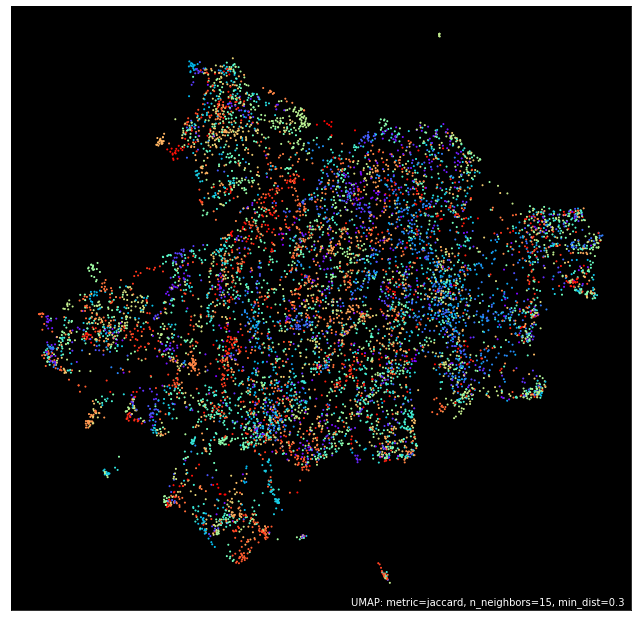

In [27]:
abv_label = popular_beer.beer_abv.fillna(0)
umap_plot = umap.plot.points(beer_by_authors_model, labels=popular_beer.brewery_name, theme='fire');
#umap_plot.figure.savefig(outfile+'.png', dpi=300, bbox_inches='tight')

... and now for an interactive plot with mouseover.

In [29]:
abv_label = popular_beer.beer_abv.fillna(0)
hover_df = popular_beer['beer_beerid beer_name brewery_name beer_style'.split()]
f = umap.plot.interactive(beer_by_authors_model, labels=popular_beer.brewery_name, hover_data=hover_df, theme='fire', point_size=5);
#save(f,outfile+'.html')
show(f)

It seems that there is a fairly strong tendency to group beers from the same breweries together.  It makes some sense that reviewers tend to sample all the beers from a given brewery (especially if they like the brewery).  

Smaller niche breweries get pulled out of the main cluster as they are reviewed by a small set of individuals who haven't reviewed much else.  Thus they are strongly connected to each other and not to the main cloud.

### What if we wanted to only group beer by the users that liked them?

Are two beers similar if two reviewer tried them?  Perhaps not, instead lets filter to only the reviewers who enjoyed the beer.

Because this is talking about reviewers and not beer we need to filter our initial data frame and re-run our process.

Link to [Positive Reviewer Notebook](EmbedAllTheThings_Beer_by_reviewer_positive.ipynb)